[[1.00000000e-01 1.00000000e-04 1.00000000e-04]
 [9.99835699e-02 1.08959924e-04 9.36511103e-05]
 [9.99681044e-02 1.16369607e-04 8.86970850e-05]
 ...
 [6.90725571e-02 5.79127192e-06 3.08748637e-06]
 [6.90721966e-02 5.73989231e-06 3.06042205e-06]
 [6.90718392e-02 5.68903853e-06 3.03350839e-06]]


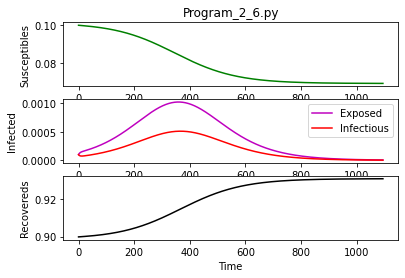

In [1]:
####################################################################
###    This is the PYTHON version of program 2.6 from page 41 of   #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SEIR epidemic with equal births and deaths.          #
### Note we no-longer explicitly model the recovered class.	       #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import scipy.integrate as spi
import numpy as np
import pylab as pl

mu=0#1/(70*365.0)
beta=620/365.0
sigma=1/14.0
gamma=1/7.0
ND=3*365.0
TS=1.0
S0=0.1
E0=1e-4
I0=1e-4
INPUT = (S0, E0, I0)

def diff_eqs(INP,t):  
	'''The main set of equations'''
	Y=np.zeros((3))
	V = INP    
	Y[0] = mu - beta * V[0] * V[2] - mu * V[0]
	Y[1] = beta * V[0] * V[2] - sigma * V[1] - mu * V[1]
	Y[2] = sigma * V[1] - gamma * V[2] - mu * V[2]
	return Y   # For odeint



t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)
RES = spi.odeint(diff_eqs,INPUT,t_range)

Rec=1. - (RES[:,0]+RES[:,1]+RES[:,2])
print(RES)

#Ploting
pl.subplot(311)
pl.plot(RES[:,0], '-g', label='Susceptibles')
pl.title('Program_2_6.py')
pl.xlabel('Time')
pl.ylabel('Susceptibles')
pl.subplot(312)
pl.plot(RES[:,1], '-m', label='Exposed')
pl.plot(RES[:,2], '-r', label='Infectious')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infected')
pl.subplot(313)
pl.plot(Rec, '-k', label='Recovereds')
pl.xlabel('Time')
pl.ylabel('Recovereds')
pl.show()

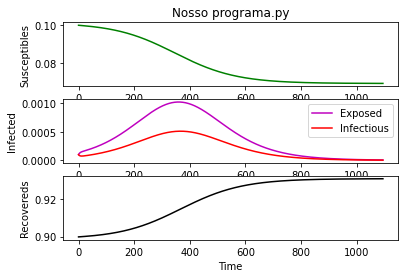

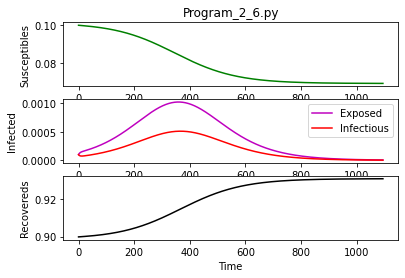

In [5]:
import numba
from numba import njit
import warnings

# Deactivate numba deprecation warnings
warnings.simplefilter('ignore', category=numba.NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=numba.NumbaPendingDeprecationWarning)

##########################################################################

# 4th order Runge-Kutta integrator
@njit(fastmath=True)
def rk4(f, y0, t, args, h=1.): 
    # f: function to be integrated; y0: initial conditions;
    # t: time points for the function to be evaluated;
    # args: extra function parameters;
    # h: time step
    
    t_ = np.arange(t[0], t[-1], h)
    n = len(t_)
    y_ = np.zeros((n, len(y0)))
    y_[0] = y0
    
    for i in range(n-1):
        
        k1 = f(t_[i], y_[i], args)
        k2 = f(t_[i] + h / 2., y_[i] + k1 * h / 2., args)
        k3 = f(t_[i] + h / 2., y_[i] + k2 * h / 2., args)
        k4 = f(t_[i] + h, y_[i] + k3 * h, args)
        y_[i+1] = y_[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    
    y = np.zeros((len(t), len(y0)))
    
    for i in range(len(y0)):
        
        y[:,i] = np.interp(t, t_, y_[:,i]) # Interpolate solution to wished time points
    
    return y

##########################################################################

class SEIRD:
    """
    SEIRD epidemic model
    """
    
    def __init__(self, dat):
        
        self.dat = dat
    
    # SEIRD parameters
    name = "SEIRD"
    ncomp = len(name)
    params = [r"$\beta$", r"$N$", r"$\gamma$", r"$\mu$", r"$c$", r"$\kappa$"]
    nparams = len(params)
    
    # Differential equations model
    @staticmethod
    @njit(fastmath=True)
    def model(t, y, params):
        
        S, E, R, I, D = y
        beta, N, gamma, mu, c, Pex = params
        
        return np.array([-beta*(1-Pex)*I*S/N - beta*Pex*E*S/N,
                         beta*(1-Pex)*I*S/N + beta*Pex*E*S/N - c*E,
                         gamma*I,
                         c*E-gamma*I-mu*I,
                         mu*I])
    
    # SEIRD equations solution
    @classmethod
    def solution(cls, t, params, y0):
    
        # y0[0] = params[1] - (y0[1] + y0[2] + y0[3] + y0[4])
        
        sol = rk4(cls.model, y0, t, params)
        
        return sol

t = np.linspace(1, ND, np.int(ND))
y0 = np.array([0.1, 1e-4, 0, 1e-4, 0], dtype=np.float64)
p = np.array([beta, 1, gamma, 0, sigma, 0])

seird_sol = SEIRD.solution(t, p, y0)

Rec2 = 1-seird_sol[:,0]-seird_sol[:,1]-seird_sol[:,3]

pl.subplot(311)
pl.plot(seird_sol[:,0], '-g', label='Susceptibles')
pl.title('Nosso programa.py')
pl.xlabel('Time')
pl.ylabel('Susceptibles')
pl.subplot(312)
pl.plot(seird_sol[:,1], '-m', label='Exposed')
pl.plot(seird_sol[:,3], '-r', label='Infectious')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infected')
pl.subplot(313)
pl.plot(Rec2, '-k', label='Recovereds')
pl.xlabel('Time')
pl.ylabel('Recovereds')
pl.show()

pl.subplot(311)
pl.plot(RES[:,0], '-g', label='Susceptibles')
pl.title('Program_2_6.py')
pl.xlabel('Time')
pl.ylabel('Susceptibles')
pl.subplot(312)
pl.plot(RES[:,1], '-m', label='Exposed')
pl.plot(RES[:,2], '-r', label='Infectious')
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infected')
pl.subplot(313)
pl.plot(Rec, '-k', label='Recovereds')
pl.xlabel('Time')
pl.ylabel('Recovereds')
pl.show()